In [1]:
import os, sys
print(sys.executable) # works this time
print(sys.version)
print(sys.version_info)

I:\mutiomics\pythonProject\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


In [9]:
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random
import matplotlib.pyplot as plt

In [10]:
adata1 = sc.read_h5ad("I:\\mutiomics\\MALDI_MALDI_brain_GruppeC_165x189_50umE0_data.h5ad")
adata2 = sc.read_h5ad("I:\\mutiomics\\10X_Visium_Ratz2022Clonal_GSM4644086_10xvisium_data.h5ad")
# 打印标题


data1_pca_results = adata1.obsm['spatial']  # PCA 结果
pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()

data2_pca_results = adata2.obsm['X_umap']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()


# 打印转换后的 Series 对象
print(data1_leiden_str)
def var_select(df, m1, m2, n):
    # 1. 筛选出列均值在 m1 和 m2 之间的行
    filtered_df = df.loc[:,(df.mean() > m1) & (df.mean() < m2)]

    # 2. 计算每行的方差，并选择前 n 个最大值所对应的索引
    variances = filtered_df.var(axis=0)/filtered_df.mean()
    sorted_indices = variances.sort_values(ascending=False).index
    selected_indices = sorted_indices[:n]

    return selected_indices.tolist()


def convert_to_array(x):
    if isinstance(x, csr_matrix):
        return x.toarray()
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Unsupported input type. Must be csr_matrix or ndarray.")
        
def tpm_normalize(counts_matrix):
    # 计算每个细胞的总表达量
    total_counts_per_cell = counts_matrix.sum(axis=1)
    # 计算每个基因的 TPM
    tpm_matrix = (counts_matrix.div(total_counts_per_cell, axis=0)) * 1e4
    return tpm_matrix


['10' '8' '8' ... '7' '7' '7']


In [46]:
#####X1:metabolic subgroup 
#####X2:spatial 
#####X3:metabolic whole group
#####normalize, pca and umap of X1,X2 and X3
#####perform CCA between X1 and X2
#####fit CCA model to X1 X2 X3

selected_indices = np.random.choice(31185, 3734, replace=False)
data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
data3_spatial_results[2] = adata1.obs["leiden"].to_numpy()
print(data3_spatial_results.head)
data1_spatial_results = pd.DataFrame(adata1.obsm['spatial']).iloc[selected_indices,:]
data1_spatial_results[2] = adata1.obs["leiden"].to_numpy()[selected_indices]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])/50
data2_spatial_results[2] = adata2.obs["leiden"].to_numpy()
print(data1_spatial_results.head)

cca = CCA(n_components=3)
cca.fit(data1_spatial_results,data2_spatial_results)
X_c = cca.transform(data1_spatial_results)
Y_c = cca.transform(data2_spatial_results)
Z_c = cca.transform(data3_spatial_results)

X_c=pd.DataFrame(X_c)
Y_c=pd.DataFrame(Y_c)
Z_c=pd.DataFrame(Z_c)

pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()

<bound method NDFrame.head of          0    1   2
0        1    1  10
1        2    1   8
2        3    1   8
3        4    1   8
4        5    1   8
...    ...  ...  ..
31180  161  189   7
31181  162  189   7
31182  163  189   7
31183  164  189   7
31184  165  189   7

[31185 rows x 3 columns]>
<bound method NDFrame.head of          0    1  2
13002  133   79  6
9720   151   59  3
10645   86   65  0
14725   41   90  2
25855  116  157  1
...    ...  ... ..
19435  131  118  1
1982     3   13  7
9793    59   60  4
20167   38  123  2
27863  144  169  0

[3734 rows x 3 columns]>


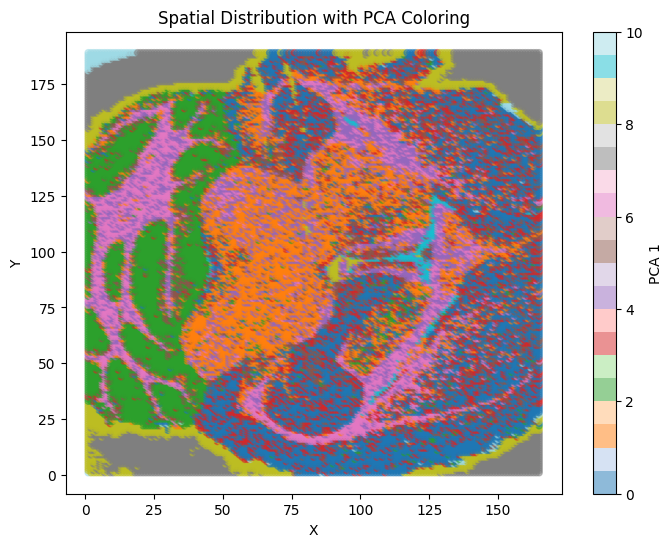

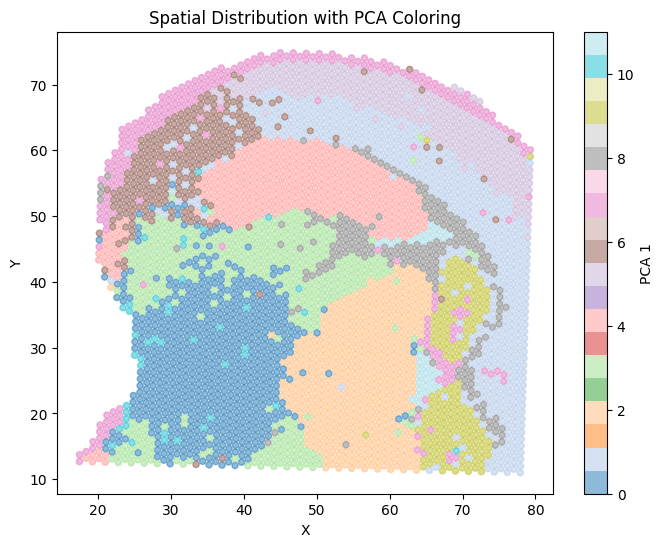

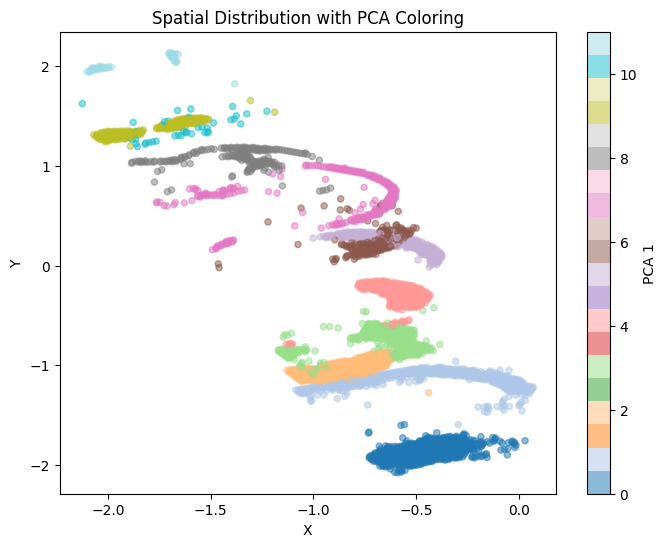

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=data1_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1], c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


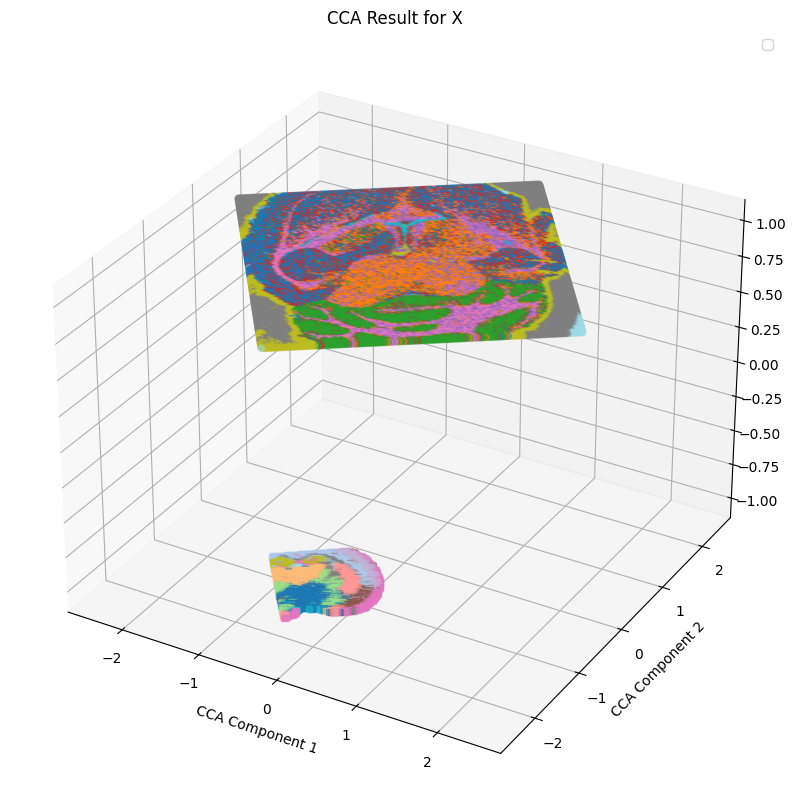

In [33]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[:, 0], Z_c.iloc[:, 1],zs=1, c=data1_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()